In [1]:
from qcportal import PortalClient
from openff.toolkit.topology import Molecule
from chargecraft.storage.storage import MoleculePropStore
from sklearn.metrics import mean_squared_error
from rdkit import Chem
from rdkit.Chem import Draw

import pandas as pd
import seaborn as sns
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
client = PortalClient(address="http://127.0.0.1:7777")


In [3]:
client.print_datasets_table()

  id  type            record_count  name
----  ------------  --------------  --------------------------------
   2  optimization            6261  PubChem_I_fragments
   7  optimization             470  conformer-test
   8  singlepoint              416  Conformer HF optimized molecules
  11  optimization              36  hf_geoms
  12  singlepoint             1428  ESP 50k opt Iodines
  13  singlepoint              416  Flexible set wb97xd


Build a dataframe from the local qcarchive

In [4]:
DATASET_NAME = "ESP 50k opt Iodines"

# client = PortalClient(address="192.168.1.1.")

dataset = client.get_dataset(dataset_type="singlepoint", dataset_name=DATASET_NAME)

add_data = []
for spec in dataset.specification_names:
    for index, _, record in dataset.iterate_records(specification_names=spec, status="complete"):
        record_data = {
            "specification": spec,
            "molecule": index,
            "tagged_smiles":Molecule.from_qcschema(record.molecule).to_smiles(mapped = True),
            "basis": record.specification.basis,
            "method": record.specification.method,
            "conformer_geom" : Molecule.from_qcschema(record.molecule).conformers[0].m,
            "dipole": record.properties["scf dipole"],
            "charges": record.properties["mbis charges"],
            "mbis dipoles": record.properties["mbis dipoles"],
            "mbis quadrupoles": record.properties["mbis quadrupoles"],
            "wall time": record.provenance.wall_time
        }
        add_data.append(record_data)

df = pd.DataFrame(add_data)
# df.to_csv("benchmark_data.csv")
df

,specification,molecule,tagged_smiles,basis,method,conformer_geom,dipole,charges,mbis dipoles,mbis quadrupoles,wall time
0,B3LYP-def2-tzvpp-ddx-4 COSMO,[O-]c1ccsn1,[C:1]1([H:7])=[C:2]([H:8])[S:3][N:4]=[C:5]1[O-:6],def2-tzvpp,b3lyp,"[[-0.09838226317818206, -0.7134580947913648, -...","[-2.511146951068973, -1.1544555919723294, 0.08...","[-0.38431747607946876, -0.22066792647695813, -...","[-0.00548802241160822, -0.02581910061411366, -...","[-5.213319526110488, -0.019598138349463157, 0....",28.026301
1,B3LYP-def2-tzvpp-ddx-4 COSMO,[S-]c1ccccc1,[c:1]1([H:8])[c:2]([H:9])[c:3]([H:10])[c:4]([S...,def2-tzvpp,b3lyp,"[[-1.4724835546710437, -0.07926821077587926, 0...","[-3.759321700042406, -0.20229196885709655, 0.0...","[-0.23704316594895652, -0.14937853452689054, -...","[0.04335967414719804, 0.0022346584432770067, -...","[-4.84510585900858, 0.006723940562006063, -3.5...",55.181361
2,B3LYP-def2-tzvpp-ddx-4 COSMO,Brc1cc[nH]c1,[C:1]1([H:7])=[C:2]([H:8])[N:3]([H:9])[C:4]([H...,def2-tzvpp,b3lyp,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.261662481162631, -0.5008752368520035, -0.1...","[-0.25827809325913165, -0.056787114714757544, ...","[0.040530467393377234, -2.987174522055977e-05,...","[-4.8205439908650725, 0.012433316162253015, -0...",41.187149
3,B3LYP-def2-tzvpp-ddx-4 COSMO,Brc1ccccc1,[c:1]1([H:8])[c:2]([H:9])[c:3]([H:10])[c:4]([B...,def2-tzvpp,b3lyp,"[[-1.4554294283684233, -0.07748397421261988, -...","[-0.6944060501369904, -0.03696026915674544, -0...","[-0.13301112864852258, -0.11664526957273408, -...","[0.028814909847833414, 0.0015035282804174348, ...","[-4.539757213205152, 0.006547290745158622, -0....",53.612614
4,B3LYP-def2-tzvpp-ddx-4 COSMO,C[Si]1(C)CCCC1,[C:1]([Si:2]1([C:7]([H:19])([H:20])[H:21])[C:3...,def2-tzvpp,b3lyp,"[[1.176853667324159, 1.8068769677841516, -0.99...","[0.06415919973358086, 0.027904906871521806, -6...","[-0.9761052833185782, 1.3073160342490424, -0.7...","[0.04318299328041229, 0.0978428870389394, -0.0...","[-6.131747305350194, -0.06962689675830258, 0.0...",177.295073
...,...,...,...,...,...,...,...,...,...,...,...
1423,HF-6-311G*-ddx-4 COSMO,Fc1ccccc1,[c:1]1([H:8])[c:2]([H:9])[c:3]([H:10])[c:4]([F...,6-311g*,hf,"[[-1.4059599630374, -0.1304423584634642, 0.014...","[-0.6687435709483083, -0.062037864480074756, 0...","[-0.21350149673352709, -0.059423732940005136, ...","[0.010555998786799204, 0.0009190547438838636, ...","[-4.740436841529863, 0.015950833648657823, 0.0...",23.560008
1424,HF-6-311G*-ddx-4 COSMO,N#Cc1ccccc1,[c:1]1([H:9])[c:2]([H:10])[c:3]([H:11])[c:4]([...,6-311g*,hf,"[[-1.633092597993143, 0.031578847905318286, -0...","[-1.817125525188196, 0.03512899161654248, -0.5...","[-0.09571824657158479, -0.1591725464239093, -0...","[0.01505349784901121, -0.0003109463716128329, ...","[-4.509620500506032, 0.011781319016970283, -0....",23.020976
1425,HF-6-311G*-ddx-4 COSMO,Nc1ccccc1,[c:1]1([H:8])[c:2]([H:9])[c:3]([H:10])[c:4]([N...,6-311g*,hf,"[[1.8942736848040755, 9.503636498997794e-05, 0...","[-0.6882046544601659, -6.430959810826975e-05, ...","[-0.2793303601116644, -0.029388203213056848, -...","[-0.010807096694704754, -2.2868299190533826e-0...","[-4.8723635700229, 0.00023107436613069624, 0.0...",35.725776
1426,HF-6-311G*-ddx-4 COSMO,O=C1CCCN1,[C:1]1([H:7])([H:8])[C:2]([H:9])([H:10])[C:3](...,6-311g*,hf,"[[-0.982553393564454, -0.41076041732955887, -0...","[-1.6305239593868777, 0.26315539493413187, 0.3...","[-0.2110962454672619, -0.3917949078330045, 0.8...","[0.06431140695939788, -0.013568804375138533, 0...","[-4.713344845616261, 0.02531857531222918, -0.0...",30.512118


Now, check if we can access the CCSD database using the chargecraft code. The list() method lists all the smiles present in the database.

In [5]:
# benchdb = MoleculePropStore('./database.db')
benchdb = MoleculePropStore('./ccsd_data.db')
benchdb.list()

['CC(C)F',
 '[O-]c1ccsn1',
 'Clc1cccnc1',
 'Brc1cc[nH]c1',
 'COCC(F)(F)F',
 'CCOB(O)O',
 'O=C1CCCN1',
 'Fc1ccccc1',
 'CC(=O)O',
 'COC',
 'CCO',
 'CC(C)=O',
 'CC(=O)[O-]',
 'Clc1ccccc1',
 'c1c[nH+]c[nH]1',
 'C1CCNC1',
 'CC',
 'CCSC',
 'CCS']

You can retrieve items by running .retrieve([smiles]) on the MoleculePropStore object. 

In [6]:
benchdb.retrieve('CC')

[MoleculePropRecord(tagged_smiles='[C:1]([C:2]([H:6])([H:7])[H:8])([H:3])([H:4])[H:5]', conformer=array([[-0.76121044,  0.01704435,  0.02132174],
        [ 0.76121109, -0.01704159, -0.02132468],
        [-1.16238031, -0.83813842,  0.56928049],
        [-1.12460595,  0.92247717,  0.51188822],
        [-1.18721113, -0.00656134, -0.98390396],
        [ 1.12458527, -0.92240799, -0.5120533 ],
        [ 1.16241327,  0.83822474, -0.5691178 ],
        [ 1.1871982 ,  0.00640308,  0.98390928]]), grid_coordinates=array([[-3.8890873 , -1.06066017, -0.70710678],
        [-3.8890873 , -1.06066017,  0.        ],
        [-3.8890873 , -1.06066017,  0.70710678],
        ...,
        [ 3.8890873 ,  1.06066017, -0.70710678],
        [ 3.8890873 ,  1.06066017,  0.        ],
        [ 3.8890873 ,  1.06066017,  0.70710678]]), esp=array([[-0.00139294],
        [-0.00151105],
        [-0.00120838],
        ...,
        [-0.00120818],
        [-0.00151079],
        [-0.00139278]]), electric_field=array([[ 5.57

Now lets combine the outputs of the CCSD database with the DFT calculations from our local qcarchive instance. 

In [7]:
prop_store = benchdb
smiles_list = df['molecule'].unique()
add_data = []
for mol in smiles_list:
    print(mol)
    try:
        item =  prop_store.retrieve(smiles=mol,method='ccsd',basis='aug-cc-pvtz')
        record_data = {
                "specification": 'ccsd-aug-cc-pVTZP',
                "molecule": mol,
                "tagged_smiles":item[0].tagged_smiles,
                "basis": 'aug-cc-pVTZP',
                "conformer_geom": item[0].conformer,
                "dipole": item[0].dipole,
                "charges": item[0].mbis_charges.flatten(),
                "mbis dipoles": item[0].mbis_dipole.flatten(),
                "mbis quadrupoles": item[0].mbis_quadropole.flatten(),
                "esp": item[0].esp_quantity,
                "grid": item[0].grid_coordinates_quantity,
            }
        add_data.append(record_data)
    except IndexError:
        continue
df_ccsd = pd.DataFrame(add_data)

df = pd.concat([df,df_ccsd], axis=0)


[O-]c1ccsn1
[S-]c1ccccc1
Brc1cc[nH]c1
Brc1ccccc1
C[Si]1(C)CCCC1
c1c[nH+]c[nH]1
C1CC[NH2+]CC1
c1ccccc1
C1CCNC1
C1CCOC1
c1ccsc1
CC
CC(=O)[O-]
CC(=O)O
CC(C)=O
CC(C)F
Cc1c[nH]c2ccccc12
CCO
CCOB(O)O
CCS
CCSC
Clc1ccccc1
Clc1cccnc1
CO[Si](C)(C)O
COC
COC[B-](F)(F)F
COCC(F)(F)F
CS(=O)(=O)[O-]
Fc1cccc(F)c1F
Fc1ccccc1
N#Cc1ccccc1
Nc1ccccc1
O=C1CCCN1
Oc1ccccc1


In [8]:
#build a pickle file of the databse for running later. 
if 'molecule' not in df.columns or 'conformer_geom' not in df.columns:
    raise ValueError("DataFrame must contain 'molecule' and 'conformer_geom' columns.")

df = df.dropna(subset=['molecule', 'conformer_geom'])

smiles_conformers_dict = {}

grouped = df.groupby('molecule')

for smiles, group in grouped:
    conformer_geoms = group['conformer_geom'].tolist()
    smiles_conformers_dict[smiles] = conformer_geoms

output_file = 'smiles_conformers.pkl'

with open(output_file, 'wb') as f:
    pickle.dump(smiles_conformers_dict, f)

print(f"Dictionary of SMILES and conformer geometries has been saved to '{output_file}'.")


Dictionary of SMILES and conformer geometries has been saved to 'smiles_conformers.pkl'.


In [9]:
# alternatively we can directly load the database associated with the csv to reproduce the figures directly here
# df = pd.read_csv('benchmark_data.csv', index_col=0)
# df
# df = pd.read_pickle('benchmark_data.pkl')
# df


Now, build a pivot table of the methods and molecules for easier plotting. 

In [10]:
df_prepared = df[['specification','molecule','basis','dipole','charges']]

pivot_df = df_prepared.pivot_table(
    index=['molecule'], 
    columns='specification', 
    values='dipole',
    aggfunc=lambda x: x.iloc[0] if not x.empty else None
).reset_index()

pivot_df

specification,molecule,B3LYP-6-311G*-ddx-4 COSMO,B3LYP-6-31G*-ddx-4 COSMO,B3LYP-def2-svpd-ddx-4 COSMO,B3LYP-def2-tzvp-ddx-4 COSMO,B3LYP-def2-tzvpd-ddx-4 COSMO,B3LYP-def2-tzvpp-ddx-4 COSMO,B3LYP-def2-tzvppd-ddx-4 COSMO,HF-6-311G*-ddx-4 COSMO,HF-6-31G*-ddx-4 COSMO,...,WB97M-D3BJ-def2-tzvpp-ddx-4 COSMO,WB97M-D3BJ-def2-tzvppd-ddx-4 COSMO,WB97X-D-6-311G*-ddx-4 COSMO,WB97X-D-6-31G*-ddx-4 COSMO,WB97X-D-def2-svpd-ddx-4 COSMO,WB97X-D-def2-tzvp-ddx-4 COSMO,WB97X-D-def2-tzvpd-ddx-4 COSMO,WB97X-D-def2-tzvpp-ddx-4 COSMO,WB97X-D-def2-tzvppd-ddx-4 COSMO,ccsd-aug-cc-pVTZP
0,Brc1cc[nH]c1,"[-1.2953943231918856, -0.5252076718872747, -0....","[-1.3118822892410549, -0.5110151770381801, -0....","[-1.2603348337478621, -0.4971843054870426, -0....","[-1.2706383862526422, -0.5051492461239029, -0....","[-1.24649691118924, -0.4906426545635796, -0.13...","[-1.261662481162631, -0.5008752368520035, -0.1...","[-1.2461721466539757, -0.4900746361492061, -0....","[-1.3886944899277864, -0.5438494968748309, -0....","[-1.3983428621718588, -0.5243996013981249, -0....",...,"[-1.2739920154524498, -0.5108837101104502, -0....","[-1.260337842416618, -0.5004050087313505, -0.1...","[-1.313044223743077, -0.5348799317732471, -0.1...","[-1.325433384466919, -0.518971197646783, -0.14...","[-1.2913230936453601, -0.5080369146707948, -0....","[-1.296100343016576, -0.5171397170871401, -0.1...","[-1.271358677022647, -0.5038106483895959, -0.1...","[-1.2866187386722174, -0.5117436542837766, -0....","[-1.270006860333325, -0.5022571140716092, -0.1...","[-1.2333162800917705, -0.4930380861029402, -0...."
1,Brc1ccccc1,"[-0.7070148411128798, -0.037632012198887566, -...","[-0.7504798607498628, -0.03994425563852033, -0...","[-0.7019719494553271, -0.037361270264899105, -...","[-0.6987129182177512, -0.0371895897292962, -0....","[-0.6965723194471138, -0.037075359365035254, -...","[-0.6944060501369904, -0.03696026915674544, -0...","[-0.6968127625872853, -0.03708809158927373, -0...","[-0.8172765019907899, -0.04349179361430444, -0...","[-0.8596626760912045, -0.04574684031043752, -0...",...,"[-0.705223227594928, -0.03753125985587502, -0....","[-0.7090718255441857, -0.03773500922595119, -0...","[-0.7238867832255096, -0.038527590816094914, -...","[-0.7640135025320376, -0.04066250985915154, -0...","[-0.732919402610662, -0.0390041489275017, -0.0...","[-0.7204711400198107, -0.03834256835436811, -0...","[-0.7150087787327948, -0.03805095469581943, -0...","[-0.7173478152137136, -0.03817617527982087, -0...","[-0.7156239288629251, -0.0380836004278482, -0....",NaN
2,C1CCNC1,"[-0.05340733622930216, 0.07182754499833566, 0....","[-0.040306160275938474, 0.05983945598220153, 0...","[-0.03508005739546949, 0.056428395755045546, 0...","[-0.03906031082588246, 0.058699069660290704, 0...","[-0.03219053856960663, 0.05356931587712177, 0....","[-0.03849316642676026, 0.057787212422743206, 0...","[-0.032267689292735824, 0.05361065450987068, 0...","[-0.03622914786590847, 0.060269069645700224, 0...","[-0.023416313261286348, 0.04944599764160662, 0...",...,"[-0.03768384362811794, 0.05807079435683127, 0....","[-0.03208273488453983, 0.05450675795946358, 0....","[-0.04850822903431773, 0.06908904968048724, 0....","[-0.034715001411026236, 0.05666578367788455, 0...","[-0.03050763573996562, 0.053861670084889735, 0...","[-0.03754108083918162, 0.05882203199288005, 0....","[-0.03208415238814499, 0.0547786966800925, 0.3...","[-0.0355803450061245, 0.05665928398685738, 0.3...","[-0.031276171104672734, 0.05406370288403339, 0...","[-0.026712145542145294, 0.05056951378575869, 0..."
3,C1CCOC1,"[-0.5432887901474004, 0.3476876857324278, -0.1...","[-0.5354847203230602, 0.3426869544644493, -0.1...","[-0.5656917949597151, 0.36203375817628647, -0....","[-0.5413539051448968, 0.3464536559728657, -0.1...","[-0.5470675531582252, 0.35011504926654524, -0....","[-0.5378627330490886, 0.34422068017565977, -0....","[-0.5468231945293454, 0.3499589508983316, -0.1...","[-0.6050645442135583, 0.38722348449260124, -0....","[-0.6089516191497442, 0.38970623134099647, -

In [11]:
pivot_df['ccsd-aug-cc-pVTZP'].iloc[0]   
pivot_df.columns 

Index(['molecule', 'B3LYP-6-311G*-ddx-4 COSMO', 'B3LYP-6-31G*-ddx-4 COSMO',
       'B3LYP-def2-svpd-ddx-4 COSMO', 'B3LYP-def2-tzvp-ddx-4 COSMO',
       'B3LYP-def2-tzvpd-ddx-4 COSMO', 'B3LYP-def2-tzvpp-ddx-4 COSMO',
       'B3LYP-def2-tzvppd-ddx-4 COSMO', 'HF-6-311G*-ddx-4 COSMO',
       'HF-6-31G*-ddx-4 COSMO', 'HF-def2-svpd-ddx-4 COSMO',
       'HF-def2-tzvp-ddx-4 COSMO', 'HF-def2-tzvpd-ddx-4 COSMO',
       'HF-def2-tzvpp-ddx-4 COSMO', 'HF-def2-tzvppd-ddx-4 COSMO',
       'PBE0-6-311G*-ddx-4 COSMO', 'PBE0-6-31G*-ddx-4 COSMO',
       'PBE0-def2-svpd-ddx-4 COSMO', 'PBE0-def2-tzvp-ddx-4 COSMO',
       'PBE0-def2-tzvpd-ddx-4 COSMO', 'PBE0-def2-tzvpp-ddx-4 COSMO',
       'PBE0-def2-tzvppd-ddx-4 COSMO', 'TPSSH-6-311G*-ddx-4 COSMO',
       'TPSSH-6-31G*-ddx-4 COSMO', 'TPSSH-def2-svpd-ddx-4 COSMO',
       'TPSSH-def2-tzvp-ddx-4 COSMO', 'TPSSH-def2-tzvpd-ddx-4 COSMO',
       'TPSSH-def2-tzvpp-ddx-4 COSMO', 'TPSSH-def2-tzvppd-ddx-4 COSMO',
       'WB97M-D3BJ-6-311G*-ddx-4 COSMO', 'WB97M-D3BJ-6

In [12]:
def normalize_dipole(dipole_vector):
    if isinstance(dipole_vector, np.ndarray):  # Check if the value is a list
        return np.linalg.norm(dipole_vector)
    else:
        return None  # Return None or some other flag value for non-list data

#Step 0: fix column names
pivot_df.columns = [col.replace('-ddx-4 COSMO', '') if 'COSMO' in col else col for col in pivot_df.columns]

# Step 1: Filter columns
# Exclude the first four columns and select only those with 'NoSolvent_nan' but not the target column itself
# columns_to_plot = [col for col in pivot_df.columns if 'gas' in col and col not in ['BaseExceptionGroupspecification','molecule','basis']]
columns_to_plot = list(pivot_df.columns)
columns_to_plot.remove('molecule')
columns_to_plot.append('HF-6-31G*')

remove_items = ['ccsd-gas-aug-cc-pvtz', 'dlpno-MP2-4-aug-cc-pvtz',
       'dlpno-MP2-4-cc-pvtz', 'dlpno-MP2-78.4-aug-cc-pvtz',
       'dlpno-MP2-78.4-cc-pvtz', 'dlpno-MP2-gas-aug-cc-pvtz',
       'dlpno-MP2-gas-cc-pvtz', 'mp2-gas-6-311G*','MP2-4-aug-cc-pvtz', 'MP2-4-cc-pvtz',
       'MP2-78.4-aug-cc-pvtz', 'MP2-78.4-cc-pvtz', 'MP2-gas-aug-cc-pvtz',
       'MP2-gas-cc-pvtz']

for item in remove_items:
    print(item)
    try:
        columns_to_plot.remove(item)
    except ValueError:
        continue

pivot_df[columns_to_plot].applymap(normalize_dipole)

# The target column for comparison
# target_column = 'ccsd-aug-cc-pVTZP'
target_column = 'ccsd-aug-cc-pVTZP'
# target_column = 'ccsd-gas-aug-cc-pvtz'
rmse_dipoles = []

# Step 2: Plotting
# Loop through the selected columns and plot them against the target column
for col in columns_to_plot:
    # plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    clean_df = pivot_df[[target_column, col]].dropna()
    pivot_df_filter = pivot_df.filter(items = [target_column, col])
    col_x = target_column
    x_tot = []
    y_tot = []
    total_skipped = 0

    for index, row in pivot_df_filter.iterrows():
        x_values = row[col_x]
        y_values = row[col]
        if (pd.isna(x_values).any() if isinstance(x_values, (list, np.ndarray)) else pd.isna(x_values)) \
            or (pd.isna(y_values).any() if isinstance(y_values, (list, np.ndarray)) else pd.isna(y_values)):
            continue
        print(type(x_values))
        if isinstance(x_values, np.ndarray) or isinstance(x_values, list):
            # Loop through each specified y-column
            # for col_y, color in col_to_color.items():
            # y_values = ast.literal_eval(row[col])
            y_values = row[col]

            if mean_squared_error(y_values, x_values) >0.15:
                total_skipped += 1
                print(f'num molecules skipped {total_skipped} for {col}')
                # print(f"excluding molecule {pivot_df.iloc[index]['molecule']}")
                continue
            x_tot.extend(x_values)
            y_tot.extend(y_values)

    if len(x_tot) == 0 or len(y_tot) == 0:
        continue
    rmse = np.sqrt(mean_squared_error(x_tot, y_tot))
    information = {"rmse": rmse,
                   "spec": col }
    rmse_dipoles.append(information)
rmse_dipoles = pd.DataFrame(rmse_dipoles)

ccsd-gas-aug-cc-pvtz
dlpno-MP2-4-aug-cc-pvtz
dlpno-MP2-4-cc-pvtz
dlpno-MP2-78.4-aug-cc-pvtz
dlpno-MP2-78.4-cc-pvtz
dlpno-MP2-gas-aug-cc-pvtz
dlpno-MP2-gas-cc-pvtz
mp2-gas-6-311G*
MP2-4-aug-cc-pvtz
MP2-4-cc-pvtz
MP2-78.4-aug-cc-pvtz
MP2-78.4-cc-pvtz
MP2-gas-aug-cc-pvtz
MP2-gas-cc-pvtz
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarr

/var/folders/8_/xls29m695yl7qglq81r94h7w0000gr/T/ipykernel_47057/3600592470.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_df[columns_to_plot].applymap(normalize_dipole)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

In [13]:
rmse_dipoles

,rmse,spec
0,0.050790,B3LYP-6-311G*
1,0.053248,B3LYP-6-31G*
2,0.015965,B3LYP-def2-svpd
3,0.024544,B3LYP-def2-tzvp
4,0.015188,B3LYP-def2-tzvpd
5,0.025409,B3LYP-def2-tzvpp
6,0.015328,B3LYP-def2-tzvppd
7,0.072444,HF-6-311G*
8,0.065398,HF-6-31G*
9,0.070436,HF-def2-svpd


In [14]:
rmse_dipoles.spec.unique()

array(['B3LYP-6-311G*', 'B3LYP-6-31G*', 'B3LYP-def2-svpd',
       'B3LYP-def2-tzvp', 'B3LYP-def2-tzvpd', 'B3LYP-def2-tzvpp',
       'B3LYP-def2-tzvppd', 'HF-6-311G*', 'HF-6-31G*', 'HF-def2-svpd',
       'HF-def2-tzvp', 'HF-def2-tzvpd', 'HF-def2-tzvpp', 'HF-def2-tzvppd',
       'PBE0-6-311G*', 'PBE0-6-31G*', 'PBE0-def2-svpd', 'PBE0-def2-tzvp',
       'PBE0-def2-tzvpd', 'PBE0-def2-tzvpp', 'PBE0-def2-tzvppd',
       'TPSSH-6-311G*', 'TPSSH-6-31G*', 'TPSSH-def2-svpd',
       'TPSSH-def2-tzvp', 'TPSSH-def2-tzvpd', 'TPSSH-def2-tzvpp',
       'TPSSH-def2-tzvppd', 'WB97M-D3BJ-6-311G*', 'WB97M-D3BJ-6-31G*',
       'WB97M-D3BJ-def2-svpd', 'WB97M-D3BJ-def2-tzvp',
       'WB97M-D3BJ-def2-tzvpd', 'WB97M-D3BJ-def2-tzvpp',
       'WB97M-D3BJ-def2-tzvppd', 'WB97X-D-6-311G*', 'WB97X-D-6-31G*',
       'WB97X-D-def2-svpd', 'WB97X-D-def2-tzvp', 'WB97X-D-def2-tzvpd',
       'WB97X-D-def2-tzvpp', 'WB97X-D-def2-tzvppd', 'ccsd-aug-cc-pVTZP'],
      dtype=object)

/var/folders/8_/xls29m695yl7qglq81r94h7w0000gr/T/ipykernel_47057/3305601036.py:43: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_rmse_sorted['method'] = df_rmse_sorted['method'].replace({
/var/folders/8_/xls29m695yl7qglq81r94h7w0000gr/T/ipykernel_47057/3305601036.py:69: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_rmse_sorted.pivot_table(index='method', columns='basis', values='rmse', aggfunc='mean')


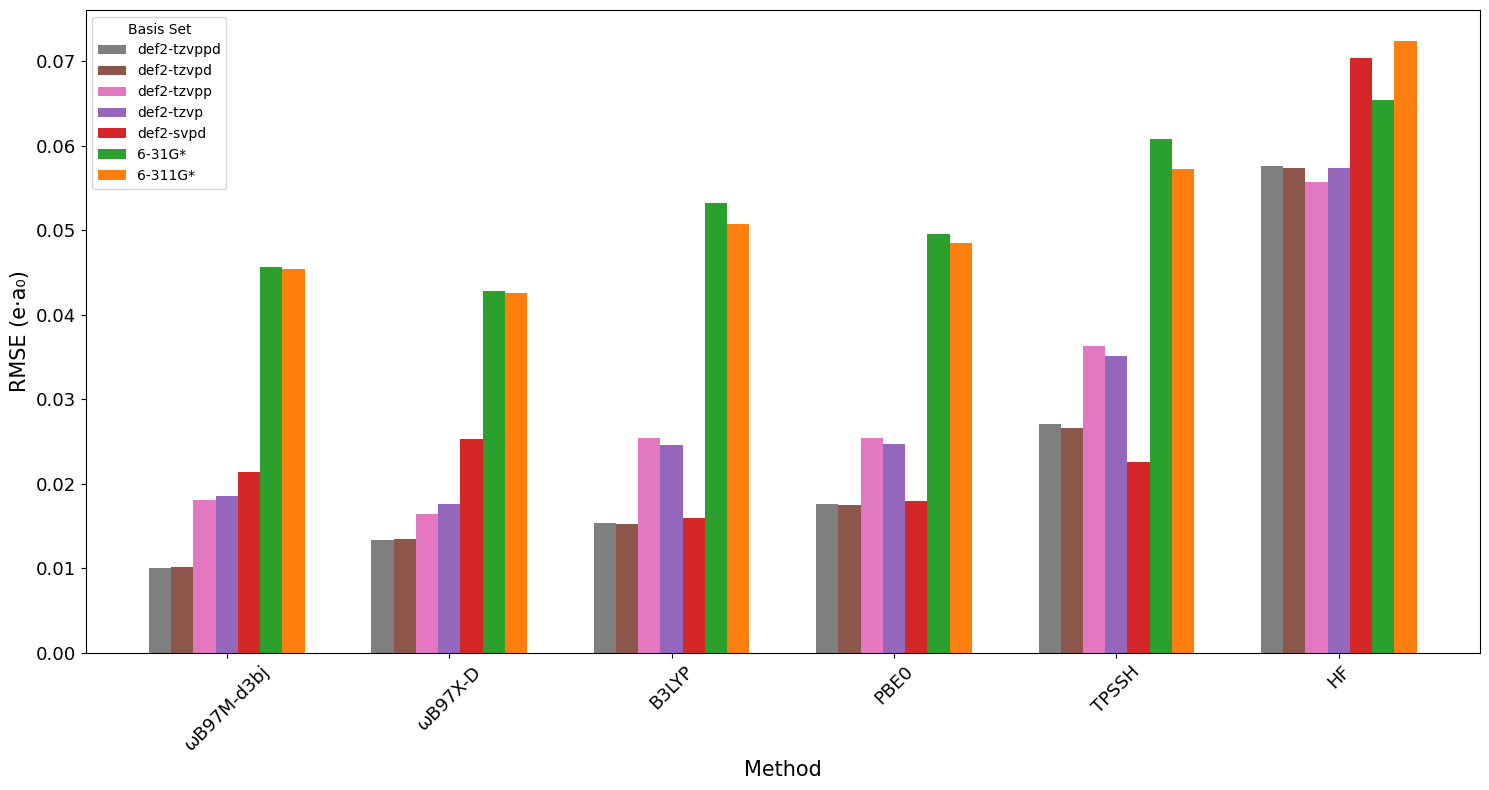

In [30]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

# Font settings
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13

# Create a DataFrame from the list
df_rmse = rmse_dipoles.copy()

# Extract method and basis from the 'spec' key
df_rmse['method'] = df_rmse['spec'].apply(lambda x: x.split('-')[0].upper())
df_rmse['basis'] = df_rmse['spec'].apply(lambda x: '-'.join(x.split('-')[-2:]))

# Calculate average RMSE for each method to determine plotting order
average_rmse_by_method = df_rmse.groupby('method')['rmse'].mean().sort_values()

# Sort dataframe based on method average RMSE
df_rmse['method_avg_rmse'] = df_rmse['method'].map(average_rmse_by_method)
df_rmse_sorted = df_rmse.sort_values(by=['method_avg_rmse', 'method', 'basis'])
df_rmse_sorted.drop('method_avg_rmse', axis=1, inplace=True)

# Ensure method is treated as categorical for plotting order
df_rmse_sorted['method'] = pd.Categorical(
    df_rmse_sorted['method'], 
    categories=average_rmse_by_method.index, 
    ordered=True
)

# Normalize basis set labels
df_rmse_sorted['basis'] = df_rmse_sorted['basis'].replace({
    'cc-pVTZ': 'cc-pvtz',
    'gas-tzvp': 'def2-tzvp',
    'gas-tzvppd': 'def2-tzvppd'
})

# Rename methods for display
df_rmse_sorted['method'] = df_rmse_sorted['method'].replace({
    'WB97X': 'ωB97X-D',
    'WB97M': 'ωB97M-d3bj',
})

# Define desired order of basis sets
desired_order = [
    'def2-tzvppd', 'def2-tzvpd', 'def2-tzvpp', 'def2-tzvp', 'def2-svpd',
    '6-31G*', '6-311G*'
]
df_rmse_sorted['basis'] = pd.Categorical(
    df_rmse_sorted['basis'], 
    categories=desired_order, 
    ordered=True
)

unique_basis = df_rmse_sorted['basis'].unique()

# prop_cycle = plt.rcParams['axes.prop_cycle']
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# colors = default_colors.by_key()['color'][:len(unique_basis)]
color_map = dict(zip(unique_basis, default_colors))


# Pivot for plotting
pivot_table = df_rmse_sorted.pivot_table(index='method', columns='basis', values='rmse', aggfunc='mean')
pivot_table_plot = pivot_table.drop(index='CCSD', errors='ignore')

# --- Plotting with centered tick labels ---
fig, ax = plt.subplots(figsize=(15, 8))
bar_width = 0.1
tick_positions = []

for idx, method in enumerate(pivot_table_plot.index):
    row = pivot_table_plot.loc[method]
    non_nan_bases = row.dropna()
    n_bars = len(non_nan_bases)

    # Start position to center bars
    start = idx - (n_bars - 1) / 2 * bar_width
    for i, (basis, value) in enumerate(non_nan_bases.items()):
        position = start + i * bar_width
        ax.bar(position, value, width=bar_width, color=color_map[basis], label=basis if idx == 0 else "")
    
    # Store tick position at center of group
    tick_positions.append(start + (n_bars - 1) / 2 * bar_width)

# Unique legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Basis Set')

# Final axis setup
ax.set_xticks(tick_positions)
ax.set_xticklabels(pivot_table_plot.index, rotation=45)
ax.set_xlabel('Method')
ax.set_ylabel('RMSE (e·a₀)')

plt.tight_layout()
plt.savefig("Method_Basis_Dipoles.png", dpi=300, bbox_inches='tight')
plt.show()


In [16]:

df_rmse_sorted

,rmse,spec,method,basis
42,0.000000,ccsd-aug-cc-pVTZP,CCSD,NaN
28,0.045395,WB97M-D3BJ-6-311G*,ωB97M-d3bj,6-311G*
29,0.045612,WB97M-D3BJ-6-31G*,ωB97M-d3bj,6-31G*
30,0.021382,WB97M-D3BJ-def2-svpd,ωB97M-d3bj,def2-svpd
31,0.018519,WB97M-D3BJ-def2-tzvp,ωB97M-d3bj,def2-tzvp
32,0.010097,WB97M-D3BJ-def2-tzvpd,ωB97M-d3bj,def2-tzvpd
33,0.018121,WB97M-D3BJ-def2-tzvpp,ωB97M-d3bj,def2-tzvpp
34,0.010059,WB97M-D3BJ-def2-tzvppd,ωB97M-d3bj,def2-tzvppd
35,0.042621,WB97X-D-6-311G*,ωB97X-D,6-311G*
36,0.042779,WB97X-D-6-31G*,ωB97X-D,6-31G*


In [17]:
df_prepared = df[['specification','molecule','basis','dipole','charges']]

pivot_df = df_prepared.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='charges',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()

pivot_df
pivot_df.to_csv('charge_results.csv')

In [18]:
pivot_df

specification,molecule,B3LYP-6-311G*-ddx-4 COSMO,B3LYP-6-31G*-ddx-4 COSMO,B3LYP-def2-svpd-ddx-4 COSMO,B3LYP-def2-tzvp-ddx-4 COSMO,B3LYP-def2-tzvpd-ddx-4 COSMO,B3LYP-def2-tzvpp-ddx-4 COSMO,B3LYP-def2-tzvppd-ddx-4 COSMO,HF-6-311G*-ddx-4 COSMO,HF-6-31G*-ddx-4 COSMO,...,WB97M-D3BJ-def2-tzvpp-ddx-4 COSMO,WB97M-D3BJ-def2-tzvppd-ddx-4 COSMO,WB97X-D-6-311G*-ddx-4 COSMO,WB97X-D-6-31G*-ddx-4 COSMO,WB97X-D-def2-svpd-ddx-4 COSMO,WB97X-D-def2-tzvp-ddx-4 COSMO,WB97X-D-def2-tzvpd-ddx-4 COSMO,WB97X-D-def2-tzvpp-ddx-4 COSMO,WB97X-D-def2-tzvppd-ddx-4 COSMO,ccsd-aug-cc-pVTZP
0,Brc1cc[nH]c1,"[-0.2718169739839899, -0.06638200574420736, -0...","[-0.2482689641540761, -0.034626250125769045, -...","[-0.24992836436246707, -0.03223570473243371, -...","[-0.26136243513826357, -0.060489552455425956, ...","[-0.2578522365806676, -0.057113602714217934, -...","[-0.25827809325913165, -0.056787114714757544, ...","[-0.2557683121122133, -0.05576020114655759, -0...","[-0.29280868788488296, -0.018471908992002607, ...","[-0.27782482476862236, 0.00331574554063152, -0...",...,"[-0.26887485728517757, -0.0532344370959924, -0...","[-0.2669213879316715, -0.05364807189170726, -0...","[-0.2815537973682308, -0.06571299079855751, -0...","[-0.2638008923230663, -0.041483777703687566, -...","[-0.26132066219431344, -0.032026061036999724, ...","[-0.26976011184827603, -0.057769614416716776, ...","[-0.2673324976431785, -0.055246939675787546, -...","[-0.2671358907326391, -0.05433421468582695, -0...","[-0.26537351293064254, -0.0541030341914177, -0...","[-0.2646661933457908, -0.049086306265596034, -..."
1,Brc1ccccc1,"[-0.14133832080761807, -0.12325871142526136, -...","[-0.12704985040538905, -0.11106605038094969, -...","[-0.12425994745758652, -0.10776474760087404, -...","[-0.13503707535023884, -0.11913962625509021, -...","[-0.13343465626300183, -0.11686532314252582, -...","[-0.13301112864852258, -0.11664526957273408, -...","[-0.13216093863171263, -0.11586417750566737, -...","[-0.1447943855662272, -0.12993539763109643, -0...","[-0.13493257685220886, -0.12186251166082177, -...",...,"[-0.13914253367611173, -0.12286203875434452, -...","[-0.13869439254664773, -0.1228705810014542, -0...","[-0.14892260292693155, -0.13082167620801308, -...","[-0.13884794264558634, -0.12268411516275078, -...","[-0.13315008963897979, -0.11682771992222521, -...","[-0.14201585213892762, -0.12607602599241804, -...","[-0.14122910854258122, -0.12485511837477163, -...","[-0.14036046547455888, -0.12398688877649092, -...","[-0.14013168691598743, -0.12402103847689007, -...",NaN
2,C1CCNC1,"[-0.2279938236009933, -0.22809390626310885, 0....","[-0.2129444395500667, -0.21302616185030585, 0....","[-0.2067937521928401, -0.20693149577116707, 0....","[-0.21636290254182164, -0.2164766987117448, 0....","[-0.21765815368061836, -0.21778031676147305, 0...","[-0.21435845314470744, -0.2144790566621501, 0....","[-0.21640130225011076, -0.21652989152119667, 0...","[-0.21185677229070005, -0.21194751007209334, 0...","[-0.20387090449803297, -0.20394493036572064, 0...",...,"[-0.2316225707415443, -0.23174161037979363, 0....","[-0.23516452569945723, -0.23530140679203895, 0...","[-0.24476403757928147, -0.24485724985400759, 0...","[-0.23508551825483642, -0.2351626001092943, 0....","[-0.22498251548329865, -0.22511385361923575, 0...","[-0.23501279186658414, -0.23512263074908324, 0...","[-0.23644534657992217, -0.23656524953274943, 0...","[-0.23303411345790528, -0.23314854841014213, 0...","[-0.23552205542611546, -0.23564824556948955, 0...","[-0.22799152875452647, -0.22812392019880687, 0..."
3,C1CCOC1,"[-0.2880734750415554, -0.2880917666758534, 0.1...","[-0.269985244661781, -0.26999769865655504, 0.1...","[-0.257831976327678, -0.25785262665368336, 0.1...","[-0.27201703522699194, -0.2720381481282204, 0....","[-0.2723241043398373, -0.27234325941147464, 0....","[-0.27127132244567376, -0.27129364558793057, 0...","[-0.27128934300392504, -0.2713094547416372, 0....","[-0.27494939943492386, -0.2749581695600586, 0....","[-0.2633086487464382, -0.2633130918413161, 0

In [19]:

df_wall_time = df[['specification','molecule','basis','dipole','charges','wall time']]

pivot_df_wall_time = df_wall_time.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='wall time',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()

pivot_df_wall_time


specification,molecule,B3LYP-6-311G*-ddx-4 COSMO,B3LYP-6-31G*-ddx-4 COSMO,B3LYP-def2-svpd-ddx-4 COSMO,B3LYP-def2-tzvp-ddx-4 COSMO,B3LYP-def2-tzvpd-ddx-4 COSMO,B3LYP-def2-tzvpp-ddx-4 COSMO,B3LYP-def2-tzvppd-ddx-4 COSMO,HF-6-311G*-ddx-4 COSMO,HF-6-31G*-ddx-4 COSMO,...,WB97M-D3BJ-def2-tzvpd-ddx-4 COSMO,WB97M-D3BJ-def2-tzvpp-ddx-4 COSMO,WB97M-D3BJ-def2-tzvppd-ddx-4 COSMO,WB97X-D-6-311G*-ddx-4 COSMO,WB97X-D-6-31G*-ddx-4 COSMO,WB97X-D-def2-svpd-ddx-4 COSMO,WB97X-D-def2-tzvp-ddx-4 COSMO,WB97X-D-def2-tzvpd-ddx-4 COSMO,WB97X-D-def2-tzvpp-ddx-4 COSMO,WB97X-D-def2-tzvppd-ddx-4 COSMO
0,Brc1cc[nH]c1,33.491380,35.020224,38.337425,41.459330,52.156195,41.187149,58.671229,31.085625,28.129402,...,100.598458,80.101196,83.122290,36.708118,39.354947,39.835359,45.057133,53.276009,40.499099,56.134256
1,Brc1ccccc1,38.784600,39.404968,45.363928,49.831823,85.269469,53.612614,69.930980,31.391948,30.995576,...,159.024256,129.989320,175.799496,42.795359,40.318588,48.773921,63.567480,67.553411,59.885317,110.508483
2,C1CCNC1,39.834290,34.546195,49.233741,50.536387,64.697090,76.742226,75.155489,28.065999,26.687054,...,126.272655,133.380229,173.486111,40.011517,31.807610,48.421123,54.102316,63.022741,59.066284,77.005259
3,C1CCOC1,35.237348,35.499802,41.888458,44.750413,61.202337,52.489557,66.145539,24.766154,24.315079,...,130.196391,103.680338,144.053299,34.511381,31.218368,40.581959,36.977845,57.509921,47.672004,52.941876
4,C1CC[NH2+]CC1,67.625262,59.399245,79.160110,85.853621,131.337379,105.074890,140.155100,49.469058,48.024020,...,267.103186,232.574543,258.181253,66.295916,53.839702,76.500194,84.540407,115.064560,114.974454,116.676224
5,CC,11.527979,10.351551,12.742241,14.250967,15.832614,16.102609,18.454492,8.252783,8.661585,...,23.868523,24.348580,25.328706,11.796396,10.405639,13.167694,13.726735,15.868922,15.454006,17.767082
6,CC(=O)O,15.655259,13.776054,18.408155,19.424185,23.674058,21.390956,24.290166,9.498492,10.069902,...,37.752533,33.605291,35.161519,15.476331,14.455518,16.626658,19.508387,22.811828,21.786593,25.129771
7,CC(=O)[O-],14.837050,12.529576,19.460326,22.220770,23.784956,20.159025,27.208471,10.036564,9.342908,...,35.790023,26.647385,39.718042,14.091165,12.950319,18.309515,18.831654,24.211622,20.384036,24.889661
8,CC(C)=O,23.910566,21.332624,27.625716,29.033240,34.543203,32.797194,40.536048,17.477951,16.435204,...,53.879991,50.844395,78.952847,24.001783,21.384178,27.919540,28.781015,34.674224,31.512166,38.608745
9,CC(C)F,28.649941,29.051744,36.133841,35.121608,41.640834,40.271046,46.761431,23.344873,19.723959,...,81.637891,83.130587,102.427056,28.574095,25.147321,33.479950,31.200769,41.781479,35.545960,42.652929


In [20]:
pivot_df.to_csv('pivot_charges.csv')

In [21]:
pivot_df['molecule'][0]

'Brc1cc[nH]c1'

In [22]:
pivot_df.columns

Index(['molecule', 'B3LYP-6-311G*-ddx-4 COSMO', 'B3LYP-6-31G*-ddx-4 COSMO',
       'B3LYP-def2-svpd-ddx-4 COSMO', 'B3LYP-def2-tzvp-ddx-4 COSMO',
       'B3LYP-def2-tzvpd-ddx-4 COSMO', 'B3LYP-def2-tzvpp-ddx-4 COSMO',
       'B3LYP-def2-tzvppd-ddx-4 COSMO', 'HF-6-311G*-ddx-4 COSMO',
       'HF-6-31G*-ddx-4 COSMO', 'HF-def2-svpd-ddx-4 COSMO',
       'HF-def2-tzvp-ddx-4 COSMO', 'HF-def2-tzvpd-ddx-4 COSMO',
       'HF-def2-tzvpp-ddx-4 COSMO', 'HF-def2-tzvppd-ddx-4 COSMO',
       'PBE0-6-311G*-ddx-4 COSMO', 'PBE0-6-31G*-ddx-4 COSMO',
       'PBE0-def2-svpd-ddx-4 COSMO', 'PBE0-def2-tzvp-ddx-4 COSMO',
       'PBE0-def2-tzvpd-ddx-4 COSMO', 'PBE0-def2-tzvpp-ddx-4 COSMO',
       'PBE0-def2-tzvppd-ddx-4 COSMO', 'TPSSH-6-311G*-ddx-4 COSMO',
       'TPSSH-6-31G*-ddx-4 COSMO', 'TPSSH-def2-svpd-ddx-4 COSMO',
       'TPSSH-def2-tzvp-ddx-4 COSMO', 'TPSSH-def2-tzvpd-ddx-4 COSMO',
       'TPSSH-def2-tzvpp-ddx-4 COSMO', 'TPSSH-def2-tzvppd-ddx-4 COSMO',
       'WB97M-D3BJ-6-311G*-ddx-4 COSMO', 'WB97M-D3BJ-6

ccsd-gas-aug-cc-pvtz
dlpno-MP2-4-aug-cc-pvtz
dlpno-MP2-4-cc-pvtz
dlpno-MP2-78.4-aug-cc-pvtz
dlpno-MP2-78.4-cc-pvtz
dlpno-MP2-gas-aug-cc-pvtz
dlpno-MP2-gas-cc-pvtz
mp2-gas-6-311G*
MP2-4-aug-cc-pvtz
MP2-4-cc-pvtz
MP2-78.4-aug-cc-pvtz
MP2-78.4-cc-pvtz
MP2-gas-aug-cc-pvtz
MP2-gas-cc-pvtz
['B3LYP-6-311G*', 'B3LYP-6-31G*', 'B3LYP-def2-svpd', 'B3LYP-def2-tzvp', 'B3LYP-def2-tzvpd', 'B3LYP-def2-tzvpp', 'B3LYP-def2-tzvppd', 'HF-6-311G*', 'HF-6-31G*', 'HF-def2-svpd', 'HF-def2-tzvp', 'HF-def2-tzvpd', 'HF-def2-tzvpp', 'HF-def2-tzvppd', 'PBE0-6-311G*', 'PBE0-6-31G*', 'PBE0-def2-svpd', 'PBE0-def2-tzvp', 'PBE0-def2-tzvpd', 'PBE0-def2-tzvpp', 'PBE0-def2-tzvppd', 'TPSSH-6-311G*', 'TPSSH-6-31G*', 'TPSSH-def2-svpd', 'TPSSH-def2-tzvp', 'TPSSH-def2-tzvpd', 'TPSSH-def2-tzvpp', 'TPSSH-def2-tzvppd', 'WB97M-D3BJ-6-311G*', 'WB97M-D3BJ-6-31G*', 'WB97M-D3BJ-def2-svpd', 'WB97M-D3BJ-def2-tzvp', 'WB97M-D3BJ-def2-tzvpd', 'WB97M-D3BJ-def2-tzvpp', 'WB97M-D3BJ-def2-tzvppd', 'WB97X-D-6-311G*', 'WB97X-D-6-31G*', 'WB97X-D-d

/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


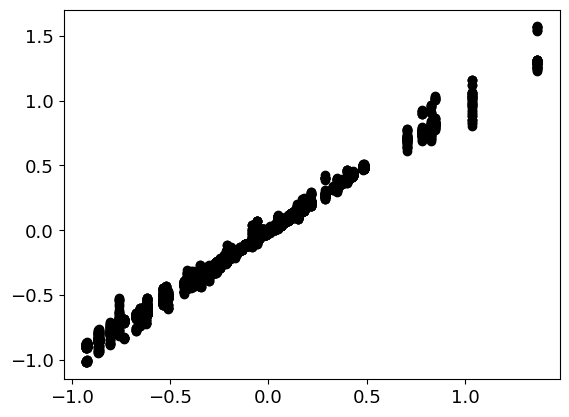

In [23]:
from sklearn.metrics import mean_squared_error

#Step 0: fix column names
pivot_df.columns = [col.replace('-ddx-4 COSMO', '') if 'COSMO' in col else col for col in pivot_df.columns]
pivot_df_wall_time.columns = [col.replace('-ddx-4 COSMO', '') if 'COSMO' in col else col for col in pivot_df_wall_time.columns]
pivot_df = pivot_df[pivot_df.molecule != 'CC(=O)O']
pivot_df = pivot_df[pivot_df.molecule != 'B(O)(O)OCC']

# Step 1: Filter columns
# Exclude the first four columns and select only those with 'NoSolvent_nan' but not the target column itself
# columns_to_plot = [col for col in pivot_df.columns if 'gas' in col and col not in ['BaseExceptionGroupspecification','molecule','basis']]
columns_to_plot = list(pivot_df.columns)
columns_to_plot.remove('molecule')
columns_to_plot.append('HF-6-31G*')
remove_items = ['ccsd-gas-aug-cc-pvtz', 'dlpno-MP2-4-aug-cc-pvtz',
       'dlpno-MP2-4-cc-pvtz', 'dlpno-MP2-78.4-aug-cc-pvtz',
       'dlpno-MP2-78.4-cc-pvtz', 'dlpno-MP2-gas-aug-cc-pvtz',
       'dlpno-MP2-gas-cc-pvtz', 'mp2-gas-6-311G*','MP2-4-aug-cc-pvtz', 'MP2-4-cc-pvtz',
       'MP2-78.4-aug-cc-pvtz', 'MP2-78.4-cc-pvtz', 'MP2-gas-aug-cc-pvtz',
       'MP2-gas-cc-pvtz']

for item in remove_items:
    print(item)
    try:
        columns_to_plot.remove(item)
    except ValueError:
        continue

print(columns_to_plot)
# The target column for comparison
target_column = 'ccsd-aug-cc-pVTZP'

rmses = []
# df_rmse = pd.DataFrame(['spec','rmse'])
# Step 2: Plotting
# Loop through the selected columns and plot them against the target column
molecule_rmses = []
for col in columns_to_plot:
    clean_df = pivot_df[[target_column, col, 'molecule']].dropna()
    pivot_df_filter = pivot_df.filter(items = [target_column, col])
    pivot_df_wall_time_filter = pivot_df_wall_time.filter(items = [col])
    col_x = target_column
    x_tot = []
    y_tot = []
    w_time_tot = []
    for (index, row), (index_wt, row_wt) in zip(pivot_df_filter.iterrows(), pivot_df_wall_time_filter.iterrows()):
        x_values = row[col_x]
        if isinstance(x_values, np.ndarray) and row[col] is not np.nan:
                x_values = x_values.tolist()
                y_values = row[col]
                x_tot.extend(x_values)
                y_tot.extend(y_values)
                if 'ccsd' not in col:
                  w_time_tot.append(row_wt[col])
                # Check if y_values is a list and has the same length as x_values
                if isinstance(y_values, list) and len(x_values) == len(y_values):
                    plt.scatter(x_values, y_values, color='black')  # Use the color assigned to this column
                    rmse_molecule = np.sqrt(mean_squared_error(y_values, x_values))
                    information_molecule = {"molecule":clean_df['molecule'][index],
                                # "spec": spec,
                                "rmse": rmse_molecule
                                }
                    molecule_rmses.append(information_molecule)
    # print(len(x_tot))
    if len(x_tot) == 0:
         continue
    rmse = np.sqrt(mean_squared_error(x_tot, y_tot))
    wall_tm_mean = np.mean(w_time_tot)
    information = {"rmse": rmse,
                   "spec": col,
                   "wall time": wall_tm_mean}
    

    rmses.append(information)

    # plt.title(f'{col} vs. {target_column} (RMSE = {rmse:.2e} e)')        
    # plt.xlabel(target_column)
    # plt.ylabel(col)
    # # Plotting details
    # plt.grid(True)  # Optional: Add a grid for better readability
    # plt.show()
df_dft_rmse = pd.DataFrame(rmses)
df_molecules_rmse  = pd.DataFrame(molecule_rmses)



/var/folders/8_/xls29m695yl7qglq81r94h7w0000gr/T/ipykernel_47057/1127161705.py:45: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_rmse_sorted['method'] = df_rmse_sorted['method'].replace({
/var/folders/8_/xls29m695yl7qglq81r94h7w0000gr/T/ipykernel_47057/1127161705.py:51: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_rmse_sorted.pivot_table(
/var/folders/8_/xls29m695yl7qglq81r94h7w0000gr/T/ipykernel_47057/1127161705.py:57: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning 

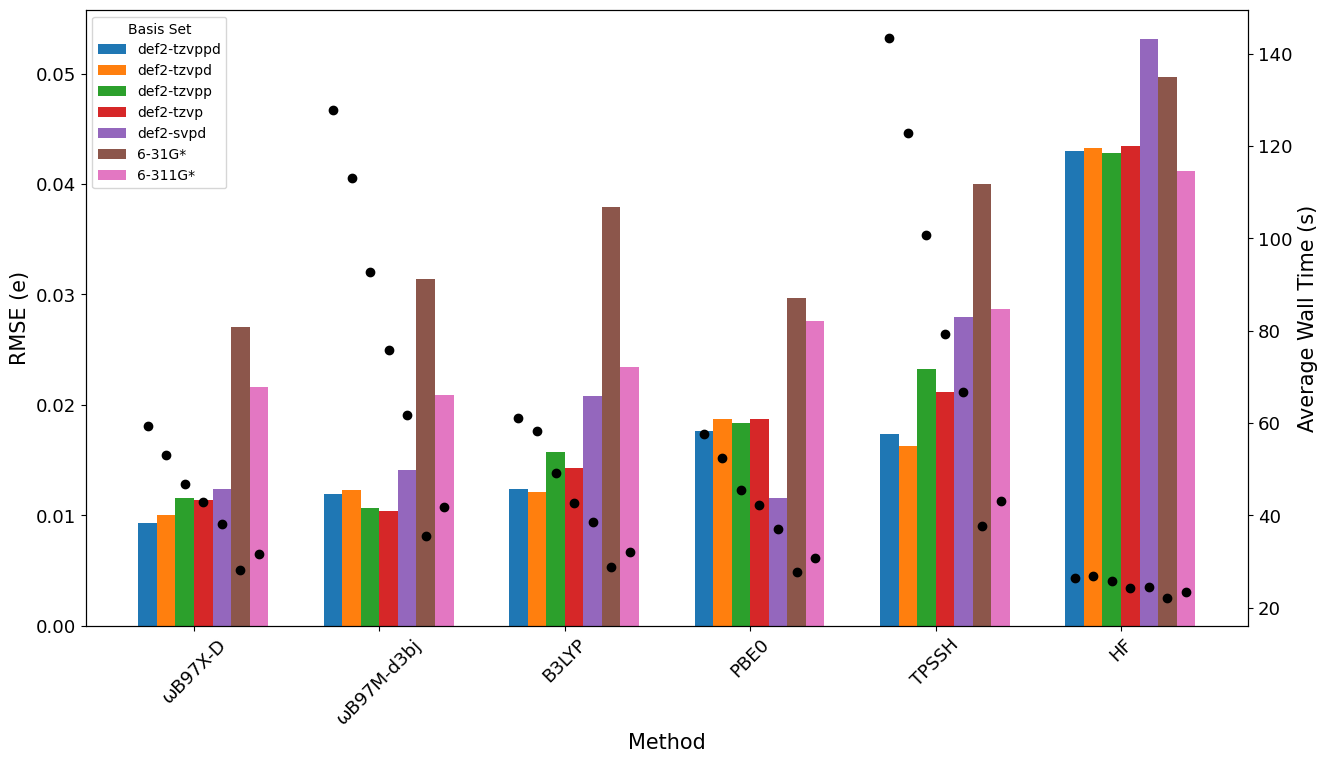

In [24]:
mpl.rcParams['font.size'] = 10          # Base font size
mpl.rcParams['axes.labelsize'] = 15     # Axis label font size
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['xtick.labelsize'] =13
mpl.rcParams['ytick.labelsize'] = 13


# Define your desired order for the basis sets
desired_order = [
    'def2-tzvppd','def2-tzvpd','def2-tzvpp', 'def2-tzvp', 'def2-svpd',
    '6-31G*', '6-311G*'
]

# Assume df_dft_rmse is your original DataFrame (make a copy for safety)
df_rmse = df_dft_rmse.copy()

# Extract 'method' and 'basis' from the 'spec' column
df_rmse['method'] = df_rmse['spec'].apply(lambda x: x.split('-')[0].upper())
df_rmse['basis'] = df_rmse['spec'].apply(lambda x: '-'.join(x.split('-')[-2:]))

# Optional: limit the DataFrame to only rows that have basis sets in your desired order
df_rmse = df_rmse[df_rmse['basis'].isin(desired_order)]

# Cast the 'basis' column as a categorical with your desired order
df_rmse['basis'] = pd.Categorical(df_rmse['basis'], categories=desired_order, ordered=True)

# (Keep the filter on RMSE as desired; note that in your sample, RMSE values are low so you might want "< 0.12")
df_rmse = df_rmse[df_rmse['rmse'] < 0.12]

# Calculate average RMSE by method to determine ordering of the methods
average_rmse_by_method = df_rmse.groupby('method')['rmse'].mean().sort_values()

# Sort the DataFrame by average RMSE, then method and basis
df_rmse['method_avg_rmse'] = df_rmse['method'].map(average_rmse_by_method)
df_rmse_sorted = df_rmse.sort_values(by=['method_avg_rmse', 'method', 'basis'])
df_rmse_sorted = df_rmse_sorted.drop(columns=['method_avg_rmse'])

# Ensure that the method column is a categorical with the proper ordering
df_rmse_sorted['method'] = pd.Categorical(
    df_rmse_sorted['method'],
    categories=average_rmse_by_method.index,
    ordered=True
)

df_rmse_sorted['method'] = df_rmse_sorted['method'].replace({
    'WB97X': 'ωB97X-D',
    'WB97M': 'ωB97M-d3bj',
})

# Create the pivot tables for RMSE and wall time
pivot_table = df_rmse_sorted.pivot_table(
    index='method',
    columns='basis',
    values='rmse',
    aggfunc='mean'
)
pivot_table_wall = df_rmse_sorted.pivot_table(
    index='method',
    columns='basis',
    values='wall time',
    aggfunc='mean'
)

# Remove the CCSD row from both pivot tables (if present)
pivot_table_plot = pivot_table.drop(index='CCSD', errors='ignore')
pivot_table_wall_plot = pivot_table_wall.drop(index='CCSD', errors='ignore')

# Drop any columns that are entirely NaN (e.g., those that might come only from CCSD)
pivot_table_plot = pivot_table_plot.dropna(axis=1, how='all')
pivot_table_wall_plot = pivot_table_wall_plot.dropna(axis=1, how='all')

# Re-index the pivot table columns to follow the desired order.
# (This will keep only those basis sets that are present in the data.)
pivot_table_plot = pivot_table_plot.reindex(columns=desired_order)
pivot_table_plot = pivot_table_plot.dropna(axis=1, how='all')
pivot_table_wall_plot = pivot_table_wall_plot.reindex(columns=desired_order)
pivot_table_wall_plot = pivot_table_wall_plot.dropna(axis=1, how='all')

# Use matplotlib's default color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Build a color mapping for each basis in the pivot table (based on the desired order)
color_map = {}
for basis in pivot_table_plot.columns:
    # Find the index in desired_order so that the color matches your specified order.
    idx = desired_order.index(basis)
    color_map[basis] = default_colors[idx % len(default_colors)]

# Now, create the plot with two y-axes (bars for RMSE and scatter for wall time)
fig, ax = plt.subplots(figsize=(15, 8))
ax2 = ax.twinx()
bar_width = 0.1

# (Optional) Calculate group width if you need it; here we compute the maximum number of non-NaN entries
counts = [np.sum(~pivot_table_plot.loc[method].isna()) for method in pivot_table_plot.index]
group_width = np.max(counts) * bar_width if counts else 0

# Loop over each basis (now in the desired order) to plot bars and scatter points
for i, basis in enumerate(pivot_table_plot.columns):
    # Compute an offset for each method based on how many basis values are present in that row
    offsets = np.array([
        bar_width * (i - np.sum(~pivot_table_plot.loc[method].isna()) / 2)
        for method in pivot_table_plot.index
    ])
    positions = np.arange(len(pivot_table_plot.index)) + offsets + 0.4

    # Plot RMSE as bars using the default color assigned to this basis
    ax.bar(positions, pivot_table_plot[basis], width=bar_width, label=basis, color=color_map[basis])
    # Plot wall time as scatter points, using the same color
    ax2.scatter(positions, pivot_table_wall_plot[basis], label=basis, color='black')

# Set the x-axis tick positions and labels based on the method names
ax.set_xticks(np.arange(len(pivot_table_plot.index)) + bar_width / 2 * (len(pivot_table_plot.columns) - 1))
ax.set_xticklabels(pivot_table_plot.index, rotation=45)

# Label the axes and add a title and legend
ax.set_xlabel('Method')
ax.set_ylabel('RMSE (e)')
ax2.set_ylabel('Average Wall Time (s)')
ax.legend(title='Basis Set')
plt.savefig("Method_and_Basis_RMSE_PartialCharges.png",dpi=300,bbox_inches='tight')
plt.show()


In [25]:
df_prepared = df[['specification','molecule','basis','dipole','charges']]

pivot_df_dipole = df_prepared.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='dipole',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()
pivot_df_dipole

specification,molecule,B3LYP-6-311G*-ddx-4 COSMO,B3LYP-6-31G*-ddx-4 COSMO,B3LYP-def2-svpd-ddx-4 COSMO,B3LYP-def2-tzvp-ddx-4 COSMO,B3LYP-def2-tzvpd-ddx-4 COSMO,B3LYP-def2-tzvpp-ddx-4 COSMO,B3LYP-def2-tzvppd-ddx-4 COSMO,HF-6-311G*-ddx-4 COSMO,HF-6-31G*-ddx-4 COSMO,...,WB97M-D3BJ-def2-tzvpp-ddx-4 COSMO,WB97M-D3BJ-def2-tzvppd-ddx-4 COSMO,WB97X-D-6-311G*-ddx-4 COSMO,WB97X-D-6-31G*-ddx-4 COSMO,WB97X-D-def2-svpd-ddx-4 COSMO,WB97X-D-def2-tzvp-ddx-4 COSMO,WB97X-D-def2-tzvpd-ddx-4 COSMO,WB97X-D-def2-tzvpp-ddx-4 COSMO,WB97X-D-def2-tzvppd-ddx-4 COSMO,ccsd-aug-cc-pVTZP
0,Brc1cc[nH]c1,"[-1.2953943231918856, -0.5252076718872747, -0....","[-1.3118822892410549, -0.5110151770381801, -0....","[-1.2603348337478621, -0.4971843054870426, -0....","[-1.2706383862526422, -0.5051492461239029, -0....","[-1.24649691118924, -0.4906426545635796, -0.13...","[-1.261662481162631, -0.5008752368520035, -0.1...","[-1.2461721466539757, -0.4900746361492061, -0....","[-1.3886944899277864, -0.5438494968748309, -0....","[-1.3983428621718588, -0.5243996013981249, -0....",...,"[-1.2739920154524498, -0.5108837101104502, -0....","[-1.260337842416618, -0.5004050087313505, -0.1...","[-1.313044223743077, -0.5348799317732471, -0.1...","[-1.325433384466919, -0.518971197646783, -0.14...","[-1.2913230936453601, -0.5080369146707948, -0....","[-1.296100343016576, -0.5171397170871401, -0.1...","[-1.271358677022647, -0.5038106483895959, -0.1...","[-1.2866187386722174, -0.5117436542837766, -0....","[-1.270006860333325, -0.5022571140716092, -0.1...","[-1.2333162800917705, -0.4930380861029402, -0...."
1,Brc1ccccc1,"[-0.7070148411128798, -0.037632012198887566, -...","[-0.7504798607498628, -0.03994425563852033, -0...","[-0.7019719494553271, -0.037361270264899105, -...","[-0.6987129182177512, -0.0371895897292962, -0....","[-0.6965723194471138, -0.037075359365035254, -...","[-0.6944060501369904, -0.03696026915674544, -0...","[-0.6968127625872853, -0.03708809158927373, -0...","[-0.8172765019907899, -0.04349179361430444, -0...","[-0.8596626760912045, -0.04574684031043752, -0...",...,"[-0.705223227594928, -0.03753125985587502, -0....","[-0.7090718255441857, -0.03773500922595119, -0...","[-0.7238867832255096, -0.038527590816094914, -...","[-0.7640135025320376, -0.04066250985915154, -0...","[-0.732919402610662, -0.0390041489275017, -0.0...","[-0.7204711400198107, -0.03834256835436811, -0...","[-0.7150087787327948, -0.03805095469581943, -0...","[-0.7173478152137136, -0.03817617527982087, -0...","[-0.7156239288629251, -0.0380836004278482, -0....",NaN
2,C1CCNC1,"[-0.05340733622930216, 0.07182754499833566, 0....","[-0.040306160275938474, 0.05983945598220153, 0...","[-0.03508005739546949, 0.056428395755045546, 0...","[-0.03906031082588246, 0.058699069660290704, 0...","[-0.03219053856960663, 0.05356931587712177, 0....","[-0.03849316642676026, 0.057787212422743206, 0...","[-0.032267689292735824, 0.05361065450987068, 0...","[-0.03622914786590847, 0.060269069645700224, 0...","[-0.023416313261286348, 0.04944599764160662, 0...",...,"[-0.03768384362811794, 0.05807079435683127, 0....","[-0.03208273488453983, 0.05450675795946358, 0....","[-0.04850822903431773, 0.06908904968048724, 0....","[-0.034715001411026236, 0.05666578367788455, 0...","[-0.03050763573996562, 0.053861670084889735, 0...","[-0.03754108083918162, 0.05882203199288005, 0....","[-0.03208415238814499, 0.0547786966800925, 0.3...","[-0.0355803450061245, 0.05665928398685738, 0.3...","[-0.031276171104672734, 0.05406370288403339, 0...","[-0.026712145542145294, 0.05056951378575869, 0..."
3,C1CCOC1,"[-0.5432887901474004, 0.3476876857324278, -0.1...","[-0.5354847203230602, 0.3426869544644493, -0.1...","[-0.5656917949597151, 0.36203375817628647, -0....","[-0.5413539051448968, 0.3464536559728657, -0.1...","[-0.5470675531582252, 0.35011504926654524, -0....","[-0.5378627330490886, 0.34422068017565977, -0....","[-0.5468231945293454, 0.3499589508983316, -0.1...","[-0.6050645442135583, 0.38722348449260124, -0....","[-0.6089516191497442, 0.38970623134099647, -

In [26]:
df_rmse

,rmse,spec,wall time,method,basis,method_avg_rmse
0,0.023397,B3LYP-6-311G*,32.142591,B3LYP,6-311G*,0.019511
1,0.037915,B3LYP-6-31G*,28.789605,B3LYP,6-31G*,0.019511
2,0.020785,B3LYP-def2-svpd,38.551195,B3LYP,def2-svpd,0.019511
3,0.014259,B3LYP-def2-tzvp,42.621951,B3LYP,def2-tzvp,0.019511
4,0.012120,B3LYP-def2-tzvpd,58.276651,B3LYP,def2-tzvpd,0.019511
5,0.015709,B3LYP-def2-tzvpp,49.220770,B3LYP,def2-tzvpp,0.019511
6,0.012390,B3LYP-def2-tzvppd,61.127872,B3LYP,def2-tzvppd,0.019511
7,0.041220,HF-6-311G*,23.405934,HF,6-311G*,0.045781
8,0.049731,HF-6-31G*,22.206347,HF,6-31G*,0.045781
9,0.053136,HF-def2-svpd,24.399962,HF,def2-svpd,0.045781


In [27]:
pivot_df_dipole['molecule'].unique()

array(['Brc1cc[nH]c1', 'Brc1ccccc1', 'C1CCNC1', 'C1CCOC1',
       'C1CC[NH2+]CC1', 'CC', 'CC(=O)O', 'CC(=O)[O-]', 'CC(C)=O',
       'CC(C)F', 'CCO', 'CCOB(O)O', 'CCS', 'CCSC', 'COC', 'COCC(F)(F)F',
       'COC[B-](F)(F)F', 'CO[Si](C)(C)O', 'CS(=O)(=O)[O-]',
       'C[Si]1(C)CCCC1', 'Cc1c[nH]c2ccccc12', 'Clc1ccccc1', 'Clc1cccnc1',
       'Fc1cccc(F)c1F', 'Fc1ccccc1', 'N#Cc1ccccc1', 'Nc1ccccc1',
       'O=C1CCCN1', 'Oc1ccccc1', '[O-]c1ccsn1', '[S-]c1ccccc1',
       'c1c[nH+]c[nH]1', 'c1ccccc1', 'c1ccsc1'], dtype=object)

In [ ]:
# esp_db.retrieve(smiles='Brc1ccccc1', method='wb97x-d', basis='def2-tzvp')

NameError: name 'esp_db' is not defined

In [31]:
esp_db =MoleculePropStore('./make_esp_db/benchmark_NEW.db') 
smiles_list = pivot_df_dipole['molecule'].unique()
df_rmse
# Some methods won't be indexed if we don't change them
# df_rmse['method'] = df_rmse['method'].replace({
#     'WB97x-d': 'ωB97X-D',
#     'WB97m-d3bj': 'ωB97M-d3bj'
# })

add_data = []
for mol in smiles_list:
    for row in df_rmse[['method','basis']].iterrows():
        method = row[1]['method']
        print(method)
        basis = row[1]['basis']
        try:
            item =  esp_db.retrieve(smiles=mol,method=method.lower(),basis=basis.lower(), implicit_solvent=None)
            record_data = {
                    "specification": f'gas-{method}-{basis}',
                    "molecule": mol,
                    "basis":basis ,
                    "conformer_geom": item[0].conformer,
                    "dipole": item[0].dipole,
                    "charges": item[0].mbis_charges.flatten(),
                    "mbis dipoles": item[0].mbis_dipole.flatten(),
                    "mbis quadrupoles": item[0].mbis_quadropole.flatten(),
                    "esp": item[0].esp_quantity,
                    "grid": item[0].grid_coordinates_quantity,
                }
            add_data.append(record_data)
        except IndexError:
            continue
df_esps = pd.DataFrame(add_data)

df_esp_all = pd.concat([df_esps,df_ccsd], axis=0)
df_esp_all

B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
HF
HF
HF
HF
HF
HF
HF
PBE0
PBE0
PBE0
PBE0
PBE0
PBE0
PBE0
TPSSH
TPSSH
TPSSH
TPSSH
TPSSH
TPSSH
TPSSH
WB97M
WB97M
WB97M
WB97M
WB97M
WB97M
WB97M
WB97X
WB97X
WB97X
WB97X
WB97X
WB97X
WB97X
CCSD
HF
B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
HF
HF
HF
HF
HF
HF
HF
PBE0
PBE0
PBE0
PBE0
PBE0
PBE0
PBE0
TPSSH
TPSSH
TPSSH
TPSSH
TPSSH
TPSSH
TPSSH
WB97M
WB97M
WB97M
WB97M
WB97M
WB97M
WB97M
WB97X
WB97X
WB97X
WB97X
WB97X
WB97X
WB97X
CCSD
HF
B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
HF
HF
HF
HF
HF
HF
HF
PBE0
PBE0
PBE0
PBE0
PBE0
PBE0
PBE0
TPSSH
TPSSH
TPSSH
TPSSH
TPSSH
TPSSH
TPSSH
WB97M
WB97M
WB97M
WB97M
WB97M
WB97M
WB97M
WB97X
WB97X
WB97X
WB97X
WB97X
WB97X
WB97X
CCSD
HF
B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
HF
HF
HF
HF
HF
HF
HF
PBE0
PBE0
PBE0
PBE0
PBE0
PBE0
PBE0
TPSSH
TPSSH
TPSSH
TPSSH
TPSSH
TPSSH
TPSSH
WB97M
WB97M
WB97M
WB97M
WB97M
WB97M
WB97M
WB97X
WB97X
WB97X
WB97X
WB97X
WB97X
WB97X
CCSD
HF
B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
B3LYP
HF
HF
HF
HF
HF
HF
HF
PBE0
PBE0

,specification,molecule,basis,conformer_geom,dipole,charges,mbis dipoles,mbis quadrupoles,esp,grid,tagged_smiles
0,gas-B3LYP-6-311G*,Brc1cc[nH]c1,6-311G*,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.2953943231918856, -0.5252076718872747, -0....","[-0.2718169739839899, -0.06638200574420736, -0...","[0.0393256200884422, 0.005172077405088979, 0.0...","[-4.826119708686556, 0.012423878459025175, -0....",[0.023377867879353587 hartree / elementary_cha...,"[[-4.242640687119285 angstrom, -0.353553390064...",NaN
1,gas-B3LYP-6-31G*,Brc1cc[nH]c1,6-31G*,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.3118822892410549, -0.5110151770381801, -0....","[-0.2482689641540761, -0.034626250125769045, -...","[0.04500788712881645, 0.019624020471631483, 0....","[-4.713857539617136, 0.010902237659234053, -0....",[0.02285397659207774 hartree / elementary_char...,"[[-4.242640687119285 angstrom, -0.353553390064...",NaN
2,gas-B3LYP-def2-svpd,Brc1cc[nH]c1,def2-svpd,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.2603348337478621, -0.4971843054870426, -0....","[-0.24992836436246707, -0.03223570473243371, -...","[0.04354087826444401, 0.006420654144094134, 0....","[-4.813906891246667, 0.018542760972589698, -0....",[0.021843365447253522 hartree / elementary_cha...,"[[-4.242640687119285 angstrom, -0.353553390064...",NaN
3,gas-B3LYP-def2-tzvp,Brc1cc[nH]c1,def2-tzvp,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.2706383862526422, -0.5051492461239029, -0....","[-0.26136243513826357, -0.060489552455425956, ...","[0.04074302739806772, -0.0001389173437196886, ...","[-4.8291691615798245, 0.013348531234931628, -0...",[0.022419127222493236 hartree / elementary_cha...,"[[-4.242640687119285 angstrom, -0.353553390064...",NaN
4,gas-B3LYP-def2-tzvpd,Brc1cc[nH]c1,def2-tzvpd,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.24649691118924, -0.4906426545635796, -0.13...","[-0.2578522365806676, -0.057113602714217934, -...","[0.03986754055610189, -0.004272962030433441, 0...","[-4.824186247448815, 0.01531323519082067, -0.0...",[0.02172623772435606 hartree / elementary_char...,"[[-4.242640687119285 angstrom, -0.353553390064...",NaN
...,...,...,...,...,...,...,...,...,...,...,...
14,ccsd-aug-cc-pVTZP,Clc1cccnc1,aug-cc-pVTZP,"[[1.271129245950723, 0.36186571238410764, -0.0...","[0.5973983888411567, 0.5330058588158124, -0.00...","[-0.2450279214750253, -0.07929388977509076, 0....","[-0.018907274959616388, 0.026731408367702526, ...","[-4.8113892697872735, 0.05481356638102052, 0.0...","[[-0.0037215612 hartree / elementary_charge], ...","[[-5.656854249492384 angstrom, 4.8107501820543...",[c:1]1([H:8])[c:2]([H:9])[c:3]([Cl:7])[c:4]([H...
15,ccsd-aug-cc-pVTZP,COC,aug-cc-pVTZP,"[[1.1289908789555647, -0.3010434909209451, -0....","[-0.13556443243616334, -0.4193059677989641, 0....","[-0.057086798919978914, -0.3446153491838415, -...","[-0.10718225553533764, 0.11808736020431847, -0...","[-4.495419003176553, -0.04309044879550526, 0.0...","[[0.004148395 hartree / elementary_charge], [0...","[[-4.242640685943341 angstrom, -0.707106781774...",[C:1]([O:2][C:3]([H:7])([H:8])[H:9])([H:4])([H...
16,ccsd-aug-cc-pVTZP,COCC(F)(F)F,aug-cc-pVTZP,"[[1.645363531851785, -0.5731605712105475, 0.18...","[0.5210875760898119, -0.509948642910512, -0.55...","[-0.08246256631524243, -0.30194813544771487, -...","[-0.08358812836680773, 0.1334838740622507, -0....","[-4.519742088568253, -0.05655814536672755, 0.0...","[[-0.0066054939 hartree / elementary_charge], ...","[[-5.303300859340083 angstrom, -0.707106781186...",[C:1]([O:2][C:3]([C:4]([F:5])([F:6])[F:7])([H:...
17,ccsd-aug-cc-pVTZP,Fc1ccccc1,aug-cc-pVTZP,"[[-1.405959963037374, -0.1304423584634894, 0.0...","[-0.5526169030549752, -0.051250430602936436, 0...","[-0.19055921117170935, -0.06946168508050639, -...","[0.025923546052146734, 0.0023551662273127113, ...","[-4.713605206975114, 0.012047368575809386, 0.0...","[[0.0094097829 hartree / elementary_charge], [...","[[-4.596194077712554 angstrom, -1.060660172220...",[c:1]1([H:8])

In [32]:
df_prepared_esp = df_esp_all[['specification','molecule','basis','dipole','charges','esp']]

pivot_df_esp = df_prepared_esp.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='esp',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()
pivot_df_esp

specification,molecule,ccsd-aug-cc-pVTZP,gas-B3LYP-6-311G*,gas-B3LYP-6-31G*,gas-B3LYP-def2-svpd,gas-B3LYP-def2-tzvp,gas-B3LYP-def2-tzvpd,gas-B3LYP-def2-tzvpp,gas-B3LYP-def2-tzvppd,gas-HF-6-311G*,...,gas-PBE0-def2-tzvpd,gas-PBE0-def2-tzvpp,gas-PBE0-def2-tzvppd,gas-TPSSH-6-311G*,gas-TPSSH-6-31G*,gas-TPSSH-def2-svpd,gas-TPSSH-def2-tzvp,gas-TPSSH-def2-tzvpd,gas-TPSSH-def2-tzvpp,gas-TPSSH-def2-tzvppd
0,Brc1cc[nH]c1,"[[0.022713849 hartree / elementary_charge], [0...",[0.023377867879353587 hartree / elementary_cha...,[0.02285397659207774 hartree / elementary_char...,[0.021843365447253522 hartree / elementary_cha...,[0.022419127222493236 hartree / elementary_cha...,[0.02172623772435606 hartree / elementary_char...,[0.022168147783048195 hartree / elementary_cha...,[0.021699951052711264 hartree / elementary_cha...,[0.02468823509736292 hartree / elementary_char...,...,[0.022162677463904577 hartree / elementary_cha...,[0.022587012523264432 hartree / elementary_cha...,[0.022134455335435597 hartree / elementary_cha...,[0.02366012693899617 hartree / elementary_char...,[0.023250826207978057 hartree / elementary_cha...,[0.02230204420671132 hartree / elementary_char...,[0.02268280930741345 hartree / elementary_char...,[0.022024168652252582 hartree / elementary_cha...,[0.02239353832699319 hartree / elementary_char...,[0.021959535323337828 hartree / elementary_cha...
1,Brc1ccccc1,NaN,[0.01068552749268464 hartree / elementary_char...,[0.010376226000822305 hartree / elementary_cha...,[0.010018860601756108 hartree / elementary_cha...,[0.010260834689116956 hartree / elementary_cha...,[0.010057763117886748 hartree / elementary_cha...,[0.01012569520089661 hartree / elementary_char...,[0.010037123355099249 hartree / elementary_cha...,[0.01218901421081234 hartree / elementary_char...,...,[0.010541051306725334 hartree / elementary_cha...,[0.010601737842739104 hartree / elementary_cha...,[0.010516734448197996 hartree / elementary_cha...,[0.010890452706412259 hartree / elementary_cha...,[0.010785912072659777 hartree / elementary_cha...,[0.010322047065683106 hartree / elementary_cha...,[0.010458796876252922 hartree / elementary_cha...,[0.01026847044622579 hartree / elementary_char...,[0.010300641220567829 hartree / elementary_cha...,[0.01022276977131977 hartree / elementary_char...
2,C1CCNC1,"[[0.0017020617 hartree / elementary_charge], [...",[0.0019819246524756563 hartree / elementary_ch...,[0.0017442097728366552 hartree / elementary_ch...,[0.001811383872614114 hartree / elementary_cha...,[0.0017900708131253474 hartree / elementary_ch...,[0.0018823085310684436 hartree / elementary_ch...,[0.0018059404846084794 hartree / elementary_ch...,[0.0018854742879219303 hartree / elementary_ch...,[0.001995042835740619 hartree / elementary_cha...,...,[0.0020594383079536155 hartree / elementary_ch...,[0.001983121206578433 hartree / elementary_cha...,[0.002063270056935439 hartree / elementary_cha...,[0.002045913689924146 hartree / elementary_cha...,[0.00191106855001564 hartree / elementary_char...,[0.0018596051973393988 hartree / elementary_ch...,[0.0018242243970381944 hartree / elementary_ch...,[0.0019334850875114022 hartree / elementary_ch...,[0.0018432431561691408 hartree / elementary_ch...,[0.001936603644364288 hartree / elementary_cha...
3,C1CCOC1,NaN,[0.006890883378544282 hartree / elementary_cha...,[0.00680060510887148 hartree / elementary_char...,[0.007038766475974281 hartree / elementary_cha...,[0.006855069767806485 hartree / elementary_cha...,[0.006908800575370634 hartree / elementary_cha...,[0.006836287166915706 hartree / elementary_cha...,[0.006897652198100617 hartree / elementary_cha...,[0.007520706997190622 hartree / elementary_cha...,...,[0.007064010667478768 hartree / elementary_cha...,[0.00699527127595753 hartree / elementary_char...,[0.0070514877821238635 hartree / elementary_ch...,[0.0069103062990409185 hartree / elementary_ch...,[0.006939775318836588 hartree / elementary_cha...,[0.007002825095452651 hartree / elementary_cha...,[0.006789707625581251 har

In [33]:
from openff.units import unit

HA_TO_KCAL_P_MOL = 627.509391  # Hartrees to kilocalories per mole

columns_to_plot = [col for col in pivot_df_esp.columns if 'gas' in col and col not in ['BaseExceptionGroupspecification','molecule','basis']]
print(columns_to_plot)

for item in remove_items:
    try:
        columns_to_plot.remove(item)
    except ValueError:
        continue

target_column = 'ccsd-aug-cc-pVTZP'
pivot_df_esp = pivot_df_esp[ pivot_df_esp['ccsd-aug-cc-pVTZP'].notna() ]

rmses = []
pivot_df_esp['molecule']
molecule_rmses = []
for col in columns_to_plot:
    clean_df = pivot_df_esp[[target_column, col, 'molecule']].dropna()
    pivot_df_filter = pivot_df_esp.filter(items = [target_column, col, 'molecule'])
    pivot_df_wall_time_filter = pivot_df_wall_time.filter(items = [col])
    col_x = target_column
    x_tot = []
    y_tot = []
    w_time_tot = []
    for (index, row), (index_wt, row_wt) in zip(pivot_df_filter.iterrows(), pivot_df_wall_time_filter.iterrows()):
        x_values = row[col_x]
        if isinstance(x_values, unit.Quantity):
                x_values = x_values.m.flatten().tolist()
                y_values = row[col].m.flatten().tolist()
                # print(row['molecule'])
                try:
                    rmse = np.sqrt(mean_squared_error(x_values, y_values))*HA_TO_KCAL_P_MOL
                except ValueError:
                    print(f"ValueError for {row['molecule']} for method {col}")
                    print(row)
                    continue
                # if rmse > 1:
                #     print(f"rmse of {row['molecule']} for method {col}")
                #     print(rmse)
                if len(x_values) != len(y_values):
                    print(f"excluding {row['molecule']} due mismatch len")
                    print(col)
                    continue
                # if "-" in row['molecule']:
                x_tot.extend(x_values)
                y_tot.extend(y_values)
    if len(x_tot) == 0:
         continue
    rmse = np.sqrt(mean_squared_error(x_tot, y_tot))*HA_TO_KCAL_P_MOL
    wall_tm_mean = np.mean(w_time_tot)
    information = {"rmse": rmse,
                   "spec": col,
                   "wall time": wall_tm_mean}
    

    rmses.append(information)

df_dft_rmse_esp = pd.DataFrame(rmses)
df_dft_rmse_esp

['gas-B3LYP-6-311G*', 'gas-B3LYP-6-31G*', 'gas-B3LYP-def2-svpd', 'gas-B3LYP-def2-tzvp', 'gas-B3LYP-def2-tzvpd', 'gas-B3LYP-def2-tzvpp', 'gas-B3LYP-def2-tzvppd', 'gas-HF-6-311G*', 'gas-HF-6-31G*', 'gas-HF-def2-svpd', 'gas-HF-def2-tzvp', 'gas-HF-def2-tzvpd', 'gas-HF-def2-tzvpp', 'gas-HF-def2-tzvppd', 'gas-PBE0-6-311G*', 'gas-PBE0-6-31G*', 'gas-PBE0-def2-svpd', 'gas-PBE0-def2-tzvp', 'gas-PBE0-def2-tzvpd', 'gas-PBE0-def2-tzvpp', 'gas-PBE0-def2-tzvppd', 'gas-TPSSH-6-311G*', 'gas-TPSSH-6-31G*', 'gas-TPSSH-def2-svpd', 'gas-TPSSH-def2-tzvp', 'gas-TPSSH-def2-tzvpd', 'gas-TPSSH-def2-tzvpp', 'gas-TPSSH-def2-tzvppd']
ValueError for CCOB(O)O for method gas-B3LYP-6-311G*
ccsd-aug-cc-pVTZP    [[0.0106525357 hartree / elementary_charge], [...
gas-B3LYP-6-311G*    [0.01084803140917669 hartree / elementary_char...
molecule                                                      CCOB(O)O
Name: 11, dtype: object
ValueError for CCOB(O)O for method gas-B3LYP-6-31G*
ccsd-aug-cc-pVTZP    [[0.0106525357 hartree /

/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _met

ValueError for CCOB(O)O for method gas-HF-def2-tzvppd
ccsd-aug-cc-pVTZP     [[0.0106525357 hartree / elementary_charge], [...
gas-HF-def2-tzvppd    [0.011401661610518216 hartree / elementary_cha...
molecule                                                       CCOB(O)O
Name: 11, dtype: object
ValueError for CCOB(O)O for method gas-PBE0-6-311G*
ccsd-aug-cc-pVTZP    [[0.0106525357 hartree / elementary_charge], [...
gas-PBE0-6-311G*     [0.011129634938987219 hartree / elementary_cha...
molecule                                                      CCOB(O)O
Name: 11, dtype: object
ValueError for CCOB(O)O for method gas-PBE0-6-31G*
ccsd-aug-cc-pVTZP    [[0.0106525357 hartree / elementary_charge], [...
gas-PBE0-6-31G*      [0.010651831013689099 hartree / elementary_cha...
molecule                                                      CCOB(O)O
Name: 11, dtype: object
ValueError for CCOB(O)O for method gas-PBE0-def2-svpd
ccsd-aug-cc-pVTZP     [[0.0106525357 hartree / elementary_charge], [...
gas

/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _met

ValueError for CCOB(O)O for method gas-TPSSH-def2-tzvpp
ccsd-aug-cc-pVTZP       [[0.0106525357 hartree / elementary_charge], [...
gas-TPSSH-def2-tzvpp    [0.010529072564372528 hartree / elementary_cha...
molecule                                                         CCOB(O)O
Name: 11, dtype: object
ValueError for CCOB(O)O for method gas-TPSSH-def2-tzvppd
ccsd-aug-cc-pVTZP        [[0.0106525357 hartree / elementary_charge], [...
gas-TPSSH-def2-tzvppd    [0.0106873301310623 hartree / elementary_charg...
molecule                                                          CCOB(O)O
Name: 11, dtype: object


/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,rmse,spec,wall time
0,0.990488,gas-B3LYP-6-311G*,NaN
1,1.014740,gas-B3LYP-6-31G*,NaN
2,0.651591,gas-B3LYP-def2-svpd,NaN
3,0.723567,gas-B3LYP-def2-tzvp,NaN
4,0.654016,gas-B3LYP-def2-tzvpd,NaN
5,0.726447,gas-B3LYP-def2-tzvpp,NaN
6,0.653286,gas-B3LYP-def2-tzvppd,NaN
7,1.186750,gas-HF-6-311G*,NaN
8,1.078744,gas-HF-6-31G*,NaN
9,1.106433,gas-HF-def2-svpd,NaN


In [ ]:
df_dft_rmse_esp.sort_values(by='rmse')

,rmse,spec,wall time
2,0.651591,gas-B3LYP-def2-svpd,NaN
6,0.653286,gas-B3LYP-def2-tzvppd,NaN
4,0.654016,gas-B3LYP-def2-tzvpd,NaN
23,0.705097,gas-TPSSH-def2-svpd,NaN
16,0.710194,gas-PBE0-def2-svpd,NaN
3,0.723567,gas-B3LYP-def2-tzvp,NaN
20,0.724064,gas-PBE0-def2-tzvppd,NaN
5,0.726447,gas-B3LYP-def2-tzvpp,NaN
18,0.727717,gas-PBE0-def2-tzvpd,NaN
25,0.733725,gas-TPSSH-def2-tzvpd,NaN


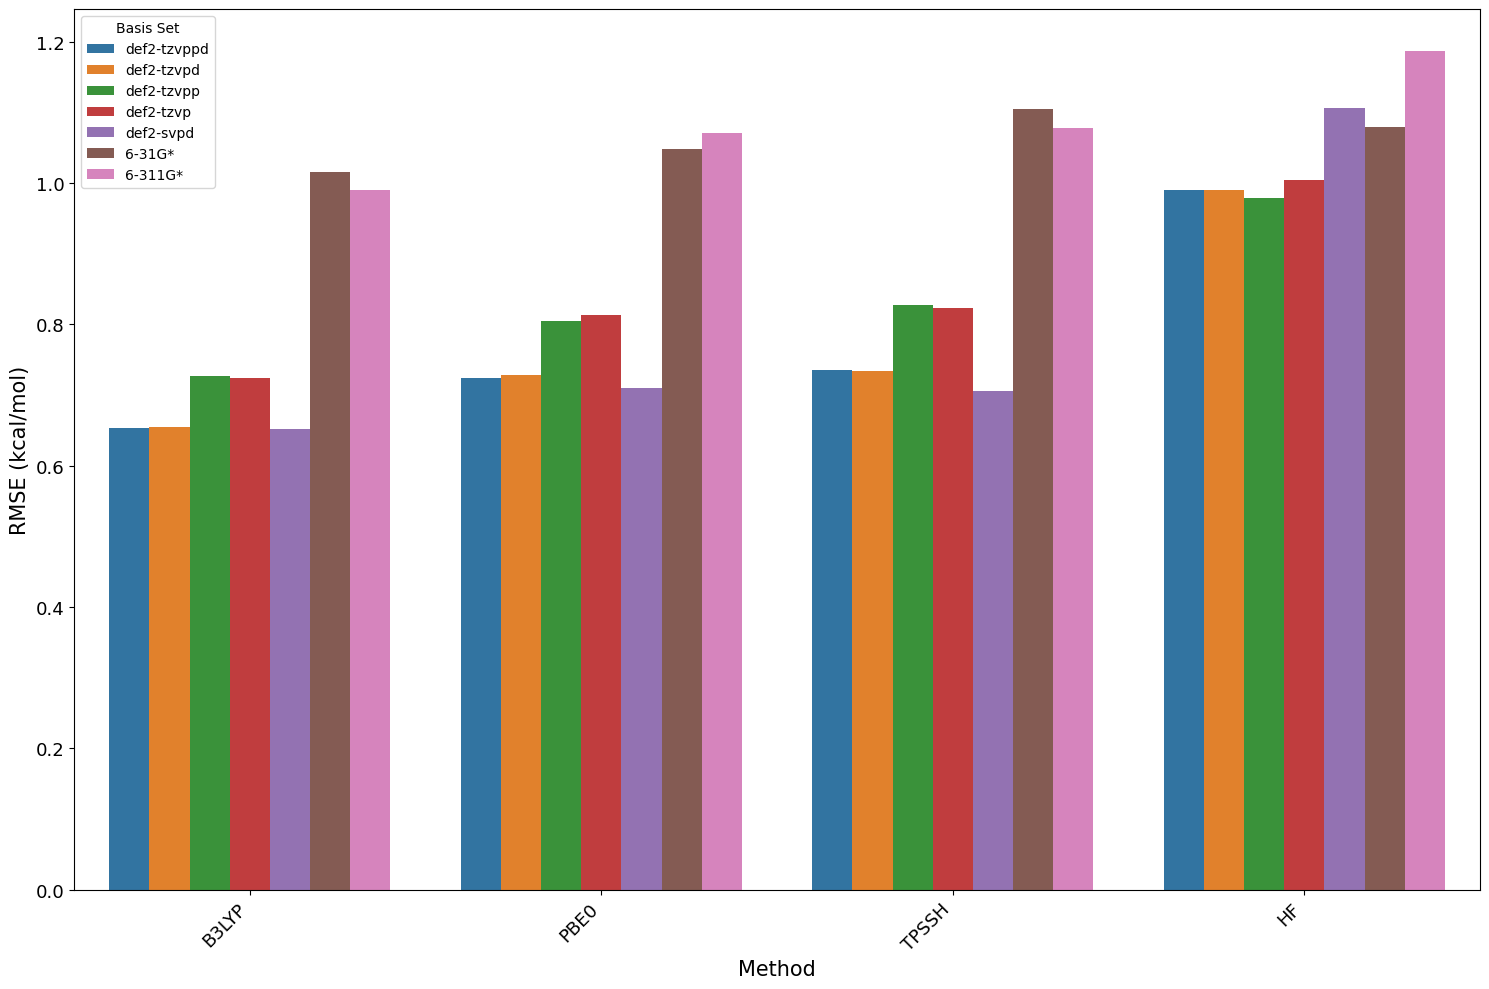

In [34]:

mpl.rcParams['font.size'] = 10          # Base font size
mpl.rcParams['axes.labelsize'] = 15     # Axis label font size
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['xtick.labelsize'] =13
mpl.rcParams['ytick.labelsize'] = 13


df = df_dft_rmse_esp

# 2) Parse out the method and basis
def parse_spec(spec):
    known_bases = {'def2-tzvppd','def2-tzvpd','def2-tzvpp', 'def2-tzvp', 'def2-svpd',
    '6-31G*', '6-311G*'}
    # Remove "gas-" from the beginning
    spec_core = spec[4:]
    parts = spec_core.split('-')
    
    # Identify the basis from the end
    for i in range(1, 3):  
        # Join the last i elements
        possible_basis = '-'.join(parts[-i:])
        if possible_basis in known_bases:
            basis = possible_basis
            # The method is everything else
            method = '-'.join(parts[:-i])
            return method, basis
    return None, None

df["method"], df["basis"] = zip(*df["spec"].apply(parse_spec))


df['method'] = df['method'].replace({
    'wb97x-d': 'ωB97X-D',
    'wb97m-d3bj': 'ωB97M-d3bj'
})

# Compute the average RMSE for each method and sort from lowest to highest RMSE
average_rmse = df.groupby('method')['rmse'].mean().sort_values()

# Create the new method order list: most accurate (lowest rmse) on the left to least accurate on the right
method_order_sorted = average_rmse.index.tolist()

basis_order = [
    'def2-tzvppd','def2-tzvpd','def2-tzvpp', 'def2-tzvp', 'def2-svpd',
    '6-31G*', '6-311G*'
]
plt.figure(figsize=(15, 10))
sns.barplot(
    data=df, 
    x="method", 
    y="rmse", 
    hue="basis",
    order=method_order_sorted, 
    hue_order=basis_order
)
# plt.title("RMSE by Method and Basis Set")
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE (kcal/mol)")
plt.xlabel("Method")
plt.legend(title="Basis Set")
plt.tight_layout()
plt.savefig('Method_and_Basis_ESP.png',dpi=300)
plt.show()
